# Showing uncertainty
> Uncertainty occurs everywhere in data science, but it's frequently left out of visualizations where it should be included. Here, we review what a confidence interval is and how to visualize them for both single estimates and continuous functions. Additionally, we discuss the bootstrap resampling technique for assessing uncertainty and how to visualize it properly. This is the Summary of lecture "Improving Your Data Visualizations in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Visualization]
- image: images/so2_compare.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

### Point estimate intervals
- When is uncertainty important?
    - Estimates from sample
        - Average of a subset
        - Linear model coefficients
- Why is uncertainty important?
    - Helps inform confidence in estimate
    - Neccessary for decision making
    - Acknowledges limitations of data

### Basic confidence intervals
You are a data scientist for a fireworks manufacturer in Des Moines, Iowa. You need to make a case to the city that your company's large fireworks show has not caused any harm to the city's air. To do this, you look at the average levels for pollutants in the week after the fourth of July and how they compare to readings taken after your last show. By showing confidence intervals around the averages, you can make a case that the recent readings were well within the normal range.

In [3]:
average_ests = pd.read_csv('./dataset/average_ests.csv', index_col=0)
average_ests

pollutant       mean   std_err             y   seen
0        CO   0.351911  0.033563  95% Interval   0.40
1       NO2  19.021429  2.200518  95% Interval  16.00
2        O3   0.043982  0.001822  95% Interval   0.05
3       SO2   0.207143  0.037518  95% Interval   0.15

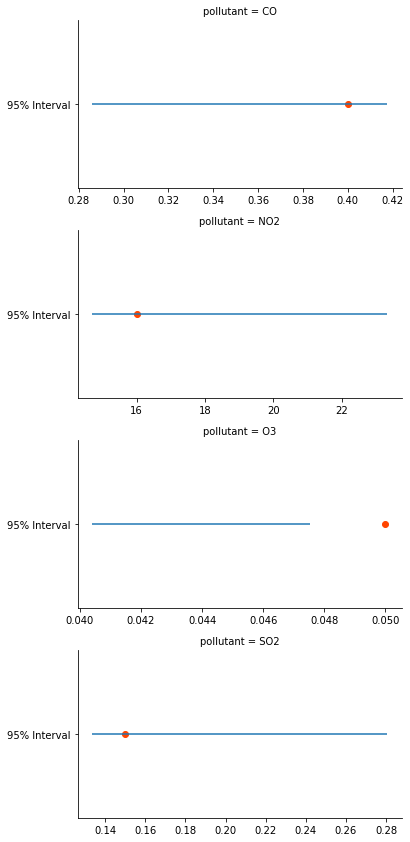

In [4]:
# Construct CI bounds for averages
average_ests['lower'] = average_ests['mean'] - 1.96 * average_ests['std_err']
average_ests['upper'] = average_ests['mean'] + 1.96 * average_ests['std_err']

# Setup a grid of plots, with non-shared x axes limits
g = sns.FacetGrid(average_ests, row='pollutant', sharex=False, aspect=2);

# Plot CI for average estimate
g.map(plt.hlines, 'y', 'lower', 'upper');

# Plot observed values for comparison and remove axes labels
g.map(plt.scatter, 'seen', 'y', color='orangered').set_ylabels('').set_xlabels('');

This simple visualization shows that all the observed values fall well within the confidence intervals for all the pollutants except for $O_3$.

### Annotating confidence intervals
Your data science work with pollution data is legendary, and you are now weighing job offers in both Cincinnati, Ohio and Indianapolis, Indiana. You want to see if the SO2 levels are significantly different in the two cities, and more specifically, which city has lower levels. To test this, you decide to look at the differences in the cities' SO2 values (Indianapolis' - Cincinnati's) over multiple years.

Instead of just displaying a p-value for a significant difference between the cities, you decide to look at the 95% confidence intervals (columns `lower` and `upper`) of the differences. This allows you to see the magnitude of the differences along with any trends over the years.

In [5]:
diffs_by_year = pd.read_csv('./dataset/diffs_by_year.csv', index_col=0)
diffs_by_year

year      mean   std_err     lower     upper
0  2013  0.840820  0.870135 -0.864645  2.546284
1  2014 -1.337625  0.761541 -2.830245  0.154996
2  2015 -0.649327  0.618175 -1.860950  0.562295

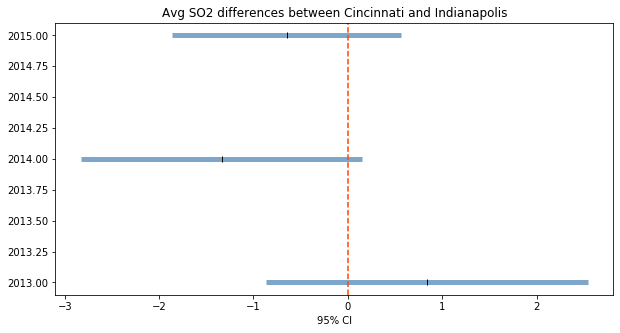

In [6]:
# Set start and ends according to intervals
# Make intervals thicker
plt.hlines(y='year', xmin='lower', xmax='upper', 
          linewidth=5, color='steelblue', alpha=0.7,
          data=diffs_by_year);

# Point estimates
plt.plot('mean', 'year', 'k|', data=diffs_by_year);

# Add a 'null' reference line at 0 and color orangered
plt.axvline(x=0, color='orangered', linestyle='--');

# Set descriptive axis labels and title
plt.xlabel('95% CI');
plt.title('Avg SO2 differences between Cincinnati and Indianapolis');

By looking at the confidence intervals you can see that the difference flipped from generally positive (more pollution in Cincinnati) in 2013 to negative (more pollution in Indianapolis) in 2014 and 2015. Given that every year's confidence interval contains the null value of zero, no P-Value would be significant, and a plot that only showed significance would have been entirely hidden this trend.

## Confidence bands

### Making a confidence band
Vandenberg Air Force Base is often used as a location to launch rockets into space. You have a theory that a recent increase in the pace of rocket launches could be harming the air quality in the surrounding region. To explore this, you plotted a 25-day rolling average line of the measurements of atmospheric $NO_2$. To help decide if any pattern observed is random-noise or not, you decide to add a 99% confidence band around your rolling mean. Adding a confidence band to a trend line can help shed light on the stability of the trend seen. This can either increase or decrease the confidence in the discovered trend.



In [7]:
vandenberg_NO2 = pd.read_csv('./dataset/vandenberg_NO2.csv', index_col=0)
vandenberg_NO2.head()

day  mean   std_err
0   25  2.56  0.452831
1   26  2.44  0.452831
2   27  2.44  0.452831
3   28  2.44  0.452831
4   29  2.40  0.452548

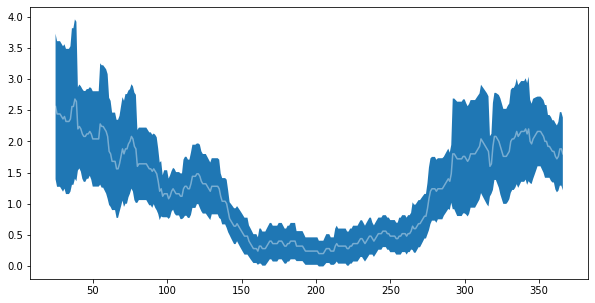

In [8]:
# Draw 99% interval bands for average NO2
vandenberg_NO2['lower'] = vandenberg_NO2['mean'] - 2.58 * vandenberg_NO2['std_err']
vandenberg_NO2['upper'] = vandenberg_NO2['mean'] + 2.58 * vandenberg_NO2['std_err']

# Plot mean estimate as a white semi-transparent line
plt.plot('day', 'mean', data=vandenberg_NO2, color='white', alpha=0.4);

# Fill between the upper and lower confidence band values
plt.fill_between(x='day', y1='lower', y2='upper', data=vandenberg_NO2);

This plot shows that the middle of the year's $NO_2$ values are not only lower than the beginning and end of the year but also are less noisy. If just the moving average line were plotted, then this potentially interesting observation would be completely missed. (Can you think of what may cause reduced variance at the lower values of the pollutant?)

### Separating a lot of bands
It is relatively simple to plot a bunch of trend lines on top of each other for rapid and precise comparisons. Unfortunately, if you need to add uncertainty bands around those lines, the plot becomes very difficult to read. Figuring out whether a line corresponds to the top of one class' band or the bottom of another's can be hard due to band overlap. Luckily in Seaborn, it's not difficult to break up the overlapping bands into separate faceted plots.

To see this, explore trends in SO2 levels for a few cities in the eastern half of the US. If you plot the trends and their confidence bands on a single plot - it's a mess. To fix, use Seaborn's `FacetGrid()` function to spread out the confidence intervals to multiple panes to ease your inspection.

In [9]:
eastern_SO2 = pd.read_csv('./dataset/eastern_SO2.csv', index_col=0)
eastern_SO2.head()

city  day    mean   std_err     lower      upper
0  Cincinnati   24  8.5150  1.297358  5.972178  11.057822
1  Cincinnati   25  8.8825  1.277753  6.378104  11.386896
2  Cincinnati   26  8.9450  1.281322  6.433609  11.456391
3  Cincinnati   27  8.4775  1.317059  5.896065  11.058935
4  Cincinnati   28  9.2325  1.416357  6.456441  12.008559

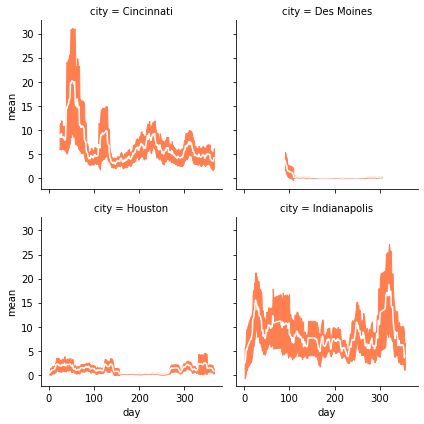

In [10]:
# setup a grid of plots with columns divided by location
g = sns.FacetGrid(eastern_SO2, col='city', col_wrap=2);

# Map interval plots to each cities data with coral colored ribbons
g.map(plt.fill_between, 'day', 'lower', 'upper', color='coral');

# Map overlaid mean plots with white line
g.map(plt.plot, 'day', 'mean', color='white');

By separating each band into its own plot you can investigate each city with ease. Here, you see that Des Moines and Houston on average have lower SO2 values for the entire year than the two cities in the Midwest. Cincinnati has a high and variable peak near the beginning of the year but is generally more stable and lower than Indianapolis.

### Cleaning up bands for overlaps
You are working for the city of Denver, Colorado and want to run an ad campaign about how much cleaner Denver's air is than Long Beach, California's air. To investigate this claim, you will compare the SO2 levels of both cities for the year 2014. Since you are solely interested in how the cities compare, you want to keep the bands on the same plot. To make the bands easier to compare, decrease the opacity of the confidence bands and set a clear legend.

In [11]:
SO2_compare = pd.read_csv('./dataset/SO2_compare.csv', index_col=0)
SO2_compare.head()

city  day    mean   std_err     lower     upper
0  Denver   20  2.5800  0.410722  1.774985  3.385015
1  Denver   21  2.6125  0.405661  1.817404  3.407596
2  Denver   22  2.6775  0.417545  1.859113  3.495887
3  Denver   23  2.6525  0.419382  1.830512  3.474488
4  Denver   24  2.7525  0.416960  1.935258  3.569742

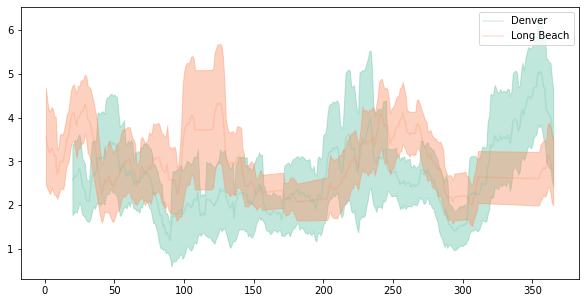

In [28]:
for city, color in [('Denver', '#66c2a5'), ('Long Beach', '#fc8d62')]:
    # Filter data to desired city
    city_data = SO2_compare[SO2_compare.city == city]
    
    # Set city interval color to desired and lower opacity
    plt.fill_between(x='day', y1='lower', y2='upper', data=city_data, color=color, alpha=0.4);
    
    # Draw a faint mean line for reference and give a label for legend
    plt.plot('day', 'mean', data=city_data, label=city, color=color, alpha=0.25);
    
plt.legend();

From these two curves you can see that during the first half of the year Long Beach generally has a higher average SO2 value than Denver, in the middle of the year they are very close, and at the end of the year Denver seems to have higher averages. However, by showing the confidence intervals, you can see however that almost none of the year shows a statistically meaningful difference in average values between the two cities.

## Beyond 95%


### 90, 95, and 99% intervals
You are a data scientist for an outdoor adventure company in Fairbanks, Alaska. Recently, customers have been having issues with SO2 pollution, leading to costly cancellations. The company has sensors for CO, NO2, and O3 but not SO2 levels.

You've built a model that predicts SO2 values based on the values of pollutants with sensors (loaded as `pollution_model`, a `statsmodels` object). You want to investigate which pollutant's value has the largest effect on your model's SO2 prediction. This will help you know which pollutant's values to pay most attention to when planning outdoor tours. To maximize the amount of information in your report, show multiple levels of uncertainty for the model estimates.

In [13]:
from statsmodels.formula.api import ols

In [14]:
pollution = pd.read_csv('./dataset/pollution_wide.csv')
pollution = pollution.query("city == 'Fairbanks' & year == 2014 & month == 11")

In [15]:
pollution_model = ols(formula='SO2 ~ CO + NO2 + O3 + day', data=pollution)
res = pollution_model.fit()

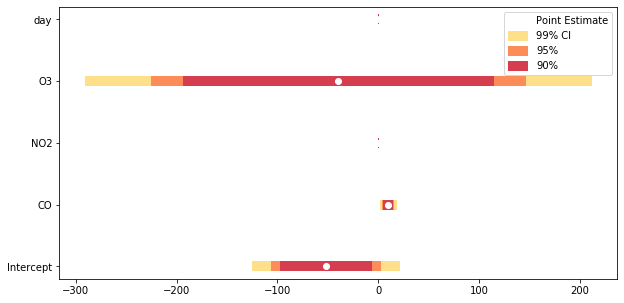

In [16]:
# Add interval percent widths
alphas = [     0.01,  0.05,   0.1] 
widths = [ '99% CI', '95%', '90%']
colors = ['#fee08b','#fc8d59','#d53e4f']

for alpha, color, width in zip(alphas, colors, widths):
    # Grab confidence interval
    conf_ints = res.conf_int(alpha)
    
    # Pass current interval color and legend label to plot
    plt.hlines(y = conf_ints.index, xmin = conf_ints[0], xmax = conf_ints[1],
               colors = color, label = width, linewidth = 10) 

# Draw point estimates
plt.plot(res.params, res.params.index, 'wo', label = 'Point Estimate')

plt.legend(loc = 'upper right')

### 90 and 95% bands
You are looking at a 40-day rolling average of the $NO_2$ pollution levels for the city of Cincinnati in 2013. To provide as detailed a picture of the uncertainty in the trend you want to look at both the 90 and 99% intervals around this rolling estimate.

To do this, set up your two interval sizes and an orange ordinal color palette. Additionally, to enable precise readings of the bands, make them semi-transparent, so the Seaborn background grids show through.

In [17]:
cinci_13_no2 = pd.read_csv('./dataset/cinci_13_no2.csv', index_col=0);
cinci_13_no2.head()

day    mean   std_err
0   82  25.425  1.447795
1   83  25.250  1.429051
2   84  25.425  1.435656
3   85  25.275  1.454728
4   86  25.025  1.438092

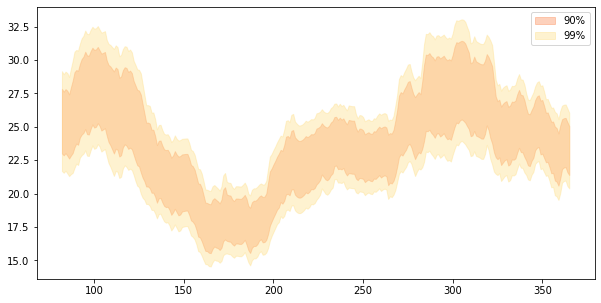

In [18]:
int_widths = ['90%', '99%']
z_scores = [1.67, 2.58]
colors = ['#fc8d59', '#fee08b']

for percent, Z, color in zip(int_widths, z_scores, colors):
    
    # Pass lower and upper confidence bounds and lower opacity
    plt.fill_between(
        x = cinci_13_no2.day, alpha = 0.4, color = color,
        y1 = cinci_13_no2['mean'] - Z * cinci_13_no2['std_err'],
        y2 = cinci_13_no2['mean'] + Z * cinci_13_no2['std_err'],
        label = percent);
    
plt.legend();

This plot shows us that throughout 2013, the average NO2 values in Cincinnati followed a cyclical pattern with the seasons. However, the uncertainty bands show that for most of the year you can't be sure this pattern is not noise at both a 90 and 99% confidence level.

### Using band thickness instead of coloring
You are a researcher investigating the elevation a rocket reaches before visual is lost and pollutant levels at Vandenberg Air Force Base. You've built a model to predict this relationship, and since you are working independently, you don't have the money to pay for color figures in your journal article. You need to make your model results plot work in black and white. To do this, you will plot the 90, 95, and 99% intervals of the effect of each pollutant as successively smaller bars.

In [19]:
rocket_model = pd.read_csv('./dataset/rocket_model.csv', index_col=0)
rocket_model

pollutant       est   std_err
0       SO2  0.138185  0.034651
1       NO2  0.320121  0.049849
2        CO  0.084282  0.024758
3        O3  0.565368  0.022191

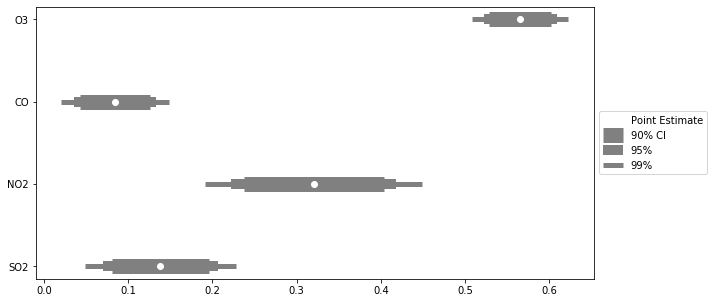

In [20]:
# Decrase interval thickness as interval widens
sizes =      [    15,  10,  5]
int_widths = ['90% CI', '95%', '99%']
z_scores =   [    1.67,  1.96,  2.58]

for percent, Z, size in zip(int_widths, z_scores, sizes):
    plt.hlines(y = rocket_model.pollutant, 
               xmin = rocket_model['est'] - Z * rocket_model['std_err'],
               xmax = rocket_model['est'] + Z * rocket_model['std_err'],
               label = percent, 
               # Resize lines and color them gray
               linewidth = size, 
               color = 'gray'); 
    
# Add point estimate
plt.plot('est', 'pollutant', 'wo', data = rocket_model, label = 'Point Estimate');
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

While less elegant than using color to differentiate interval sizes, this plot still clearly allows the reader to access the effect each pollutant has on rocket visibility. You can see that of all the pollutants, O3 has the largest effect and also the tightest confidence bounds

## Visualizing the bootstrap


### The bootstrap histogram
You are considering a vacation to Cincinnati in May, but you have a severe sensitivity to NO2. You pull a few years of pollution data from Cincinnati in May and look at a bootstrap estimate of the average $NO_2$ levels. You only have one estimate to look at the best way to visualize the results of your bootstrap estimates is with a histogram.

While you like the intuition of the bootstrap histogram by itself, your partner who will be going on the vacation with you, likes seeing percent intervals. To accommodate them, you decide to highlight the 95% interval by shading the region.

In [21]:
# Perform bootstrapped mean on a vector
def bootstrap(data, n_boots):
    return [np.mean(np.random.choice(data,len(data))) for _ in range(n_boots) ]

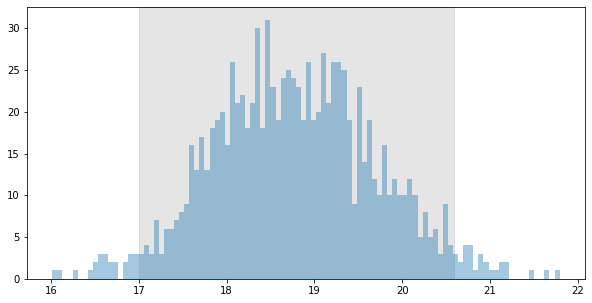

In [23]:
pollution = pd.read_csv('./dataset/pollution_wide.csv')
cinci_may_NO2 = pollution.query("city  ==  'Cincinnati' & month  ==  5").NO2

# Generate bootstrap samples
boot_means = bootstrap(cinci_may_NO2, 1000)

# Get lower and upper 95% interval bounds
lower, upper = np.percentile(boot_means, [2.5, 97.5])

# Plot shaded area for interval
plt.axvspan(lower, upper, color = 'gray', alpha = 0.2);

# Draw histogram of bootstrap samples
sns.distplot(boot_means, bins = 100, kde = False);

Your bootstrap histogram looks stable and uniform. You're now confident that the average NO2 levels in Cincinnati during your vacation should be in the range of 16 to 23.

### Bootstrapped regressions
While working for the Long Beach parks and recreation department investigating the relationship between $NO_2$ and $SO_2$ you noticed a cluster of potential outliers that you suspect might be throwing off the correlations.

Investigate the uncertainty of your correlations through bootstrap resampling to see how stable your fits are. For convenience, the bootstrap sampling is complete and is provided as `no2_so2_boot` along with `no2_so2` for the non-resampled data.

In [24]:
no2_so2 = pd.read_csv('./dataset/no2_so2.csv', index_col=0)
no2_so2_boot = pd.read_csv('./dataset/no2_so2_boot.csv', index_col=0)

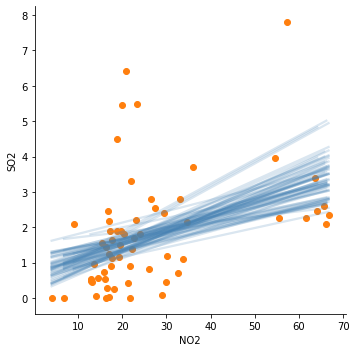

In [25]:
sns.lmplot('NO2', 'SO2', data = no2_so2_boot,
           # Tell seaborn to a regression line for each sample
           hue = 'sample', 
           # Make lines blue and transparent
           line_kws = {'color': 'steelblue', 'alpha': 0.2},
           # Disable built-in confidence intervals
           ci = None, legend = False, scatter = False);

# Draw scatter of all points
plt.scatter('NO2', 'SO2', data = no2_so2);

The outliers appear to drag down the regression lines as evidenced by the cluster of lines with more severe slopes than average. In a single plot, you have not only gotten a good idea of the variability of your correlation estimate but also the potential effects of outliers.

### Lots of bootstraps with beeswarms
As a current resident of Cincinnati, you're curious to see how the average NO2 values compare to Des Moines, Indianapolis, and Houston: a few other cities you've lived in.

To look at this, you decide to use bootstrap estimation to look at the mean NO2 values for each city. Because the comparisons are of primary interest, you will use a swarm plot to compare the estimates.

In [26]:
pollution_may = pollution.query("month == 5")
pollution_may

city  year  month  day     CO   NO2     O3   SO2
136                  Cincinnati  2013      5  121  0.640  33.0  0.055  1.85
137                  Cincinnati  2013      5  122  0.315  23.0  0.043  4.10
138                  Cincinnati  2013      5  123  0.260  13.0  0.039  4.75
139                  Cincinnati  2013      5  124  0.245  17.0  0.051  4.45
140                  Cincinnati  2013      5  125  0.230  12.0  0.032  0.85
...                         ...   ...    ...  ...    ...   ...    ...   ...
8673  Vandenberg Air Force Base  2015      5  137  0.000   1.0  0.044  0.50
8674  Vandenberg Air Force Base  2015      5  138  0.000   2.0  0.043  1.00
8675  Vandenberg Air Force Base  2015      5  139  0.000   0.0  0.041  0.50
8676  Vandenberg Air Force Base  2015      5  140  0.000   0.0  0.044  0.50
8677  Vandenberg Air Force Base  2015      5  141  0.000   0.0  0.041  0.50

[736 rows x 8 columns]

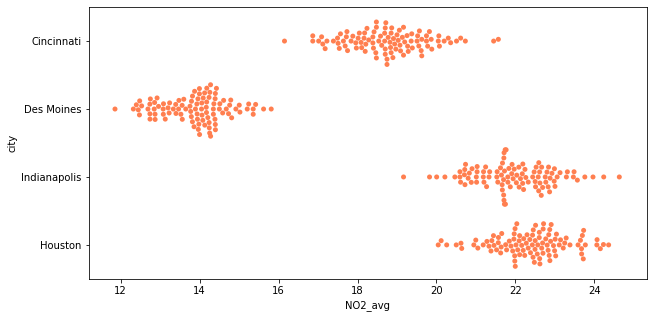

In [27]:
# Initialize a holder DataFrame for bootstrap results
city_boots = pd.DataFrame()

for city in ['Cincinnati', 'Des Moines', 'Indianapolis', 'Houston']:
    # Filter to city
    city_NO2 = pollution_may[pollution_may.city  ==  city].NO2
    # Bootstrap city data & put in DataFrame
    cur_boot = pd.DataFrame({'NO2_avg': bootstrap(city_NO2, 100), 'city': city})
    # Append to other city's bootstraps
    city_boots = pd.concat([city_boots,cur_boot])

# Beeswarm plot of averages with citys on y axis
sns.swarmplot(y = "city", x = "NO2_avg", data = city_boots, color = 'coral');

The beeswarm plots show that Indianapolis and Houston both have the highest average NO2 values, with Cincinnati falling roughly in the middle. Interestingly, you can rather confidently say that Des Moines has the lowest as nearly all its sample estimates fall below those of the other cities.